In [1]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


Word2Vec은 word to vector의 줄임말이다.  
딥러닝 모델은 입력값으로 수치값을 받기 때문에 자연어 처리 분야에서는 단더(word)들을 어떻게 수치(vector)로 변환하느냐가 딥러닝 모델의 성능을 결정하는 중요한 요소이다.

word to vector의 장점은 의미가 비슷한 단어는 벡터 공간에서 서로 가까운 위치에 존재하게 되는 비지도 학습으로 말뭉치 데이터만 있으면 손쉽게 word2Vec을 구현할 수 있다.

데이터 획득

In [2]:
corpus = [
    'king is a strong man', 
    'queen is a wise woman', 
    'boy is a young man', 
    'girl is a young woman',
    'prince is a young king', 
    'princess is a young queen', 
    'man is strong', 
    'woman is pretty',
    'prince is a boy will be king', 
    'princess is a girl will be queen'
]
print(corpus)

['king is a strong man', 'queen is a wise woman', 'boy is a young man', 'girl is a young woman', 'prince is a young king', 'princess is a young queen', 'man is strong', 'woman is pretty', 'prince is a boy will be king', 'princess is a girl will be queen']


불용어(stop words) 제거하기  
불용어란 학습에 도움이 되지도 않으면서 빈번하게 발생되는 단어를 의미하며 효율적인 학습을 위해 불용어를 데이터에서 제거한다.

In [3]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = [] # 인수로 넘어온 문장에서 불용어를 제거한 결과를 저장해서 리턴시킬 빈 리스트를 선언한다.
    # 불용어를 제거할 문장을 한줄씩 읽어가며 반복한다.
    for text in corpus:
        # 불용어를 제거하기 위해서 공백을 경계로 문장을 단어 단위로 나눈다.
        temp = text.split()
        # 불용어 개수만큼 반복하며 불용어를 제거할 문장에서 불용어를 제거한다.
        for stop_word in stop_words:
            # 문장에 포함된 불용어를 제거한다.
            while stop_word in temp:
                temp.remove(stop_word)
            # ===== while
        # ===== for
        # print(temp)
        # 불용어가 제거된 단어 사이에 공백을 넣어서 불용어가 제거된 문장을 만든다.
        # print(' '.join(temp))
        results.append(' '.join(temp))
    return results

In [4]:
corpus = remove_stop_words(corpus)
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

불용어를 제거한 후 데이터에 존재하는 단어들은 다음과 같다.

In [5]:
words = []
for text in corpus:
    for word in text.split():
        words.append(word)
print(words) # 중복되는 단어가 존재한다.

['king', 'strong', 'man', 'queen', 'wise', 'woman', 'boy', 'young', 'man', 'girl', 'young', 'woman', 'prince', 'young', 'king', 'princess', 'young', 'queen', 'man', 'strong', 'woman', 'pretty', 'prince', 'boy', 'king', 'princess', 'girl', 'queen']


불용어를 제거한 단어의 중복을 제거한다.

In [6]:
words = set(words)
print(words) # 중복되는 단어가 존재하지 않는다.

{'man', 'king', 'queen', 'boy', 'young', 'woman', 'girl', 'strong', 'prince', 'princess', 'wise', 'pretty'}


단어별 인덱스 매핑 테이블 만들기  
단어를 원-핫 인코딩으로 변환하기 위해서 가장 먼저 인덱스로 인코딩 해야하고 단어를 손쉽게 인덱싱하기 위해 key는 단어이고 value는 인덱스인 딕셔너리를 만든다.

In [7]:
for index, data in enumerate(words):
    print(index, data)

0 man
1 king
2 queen
3 boy
4 young
5 woman
6 girl
7 strong
8 prince
9 princess
10 wise
11 pretty


In [8]:
word2int = {}
for index, data in enumerate(words):
    word2int[data] = index
print(word2int)

{'man': 0, 'king': 1, 'queen': 2, 'boy': 3, 'young': 4, 'woman': 5, 'girl': 6, 'strong': 7, 'prince': 8, 'princess': 9, 'wise': 10, 'pretty': 11}


skip gram 방식으로 각 단어별 레이블을 생성한다.

In [9]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
print(sentences)

[['king', 'strong', 'man'], ['queen', 'wise', 'woman'], ['boy', 'young', 'man'], ['girl', 'young', 'woman'], ['prince', 'young', 'king'], ['princess', 'young', 'queen'], ['man', 'strong'], ['woman', 'pretty'], ['prince', 'boy', 'king'], ['princess', 'girl', 'queen']]


In [10]:
WINDOW_SIZE = 2
data = []
# 단어별 레이블을 생성할 문장의 개수만큼 반복하며 레이블을 생성한다.
for sentence in sentences:
    # print('sentence: {}'.format(sentence))
    for index, word in enumerate(sentence):
        # print('index: {}, word: {}'.format(index, word))
        for neighbor in sentence[max(index - WINDOW_SIZE, 0):min(index + WINDOW_SIZE, len(sentence)) + 1]:
            if word != neighbor:
                # print('{} neighbor: {}'.format(word, neighbor))
                data.append([word, neighbor])
            # ===== if
        # ===== for neighbor
        # print('*' * 80)
    # ===== for sentence     
    # print('=' * 80)

In [11]:
df = pd.DataFrame(data, columns=['input', 'label'])
df.head(6)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong


텐서플로우로 word2Vec 모델 구현하기

<img src="./word2vec.png" width="800" align="left"/>

In [12]:
# key(단어)에 할당된 value(인덱스)를 원-핫 인코딩으로 전환하는 함수를 만든다.
ONE_HOT_DIM = len(words)
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

for w in word2int:
    result = to_one_hot_encoding(word2int[w])
    print(result)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [13]:
# 모델을 만든다.
X = [] # 입력 단어
Y = [] # 입력 단어에 따른 레이블

# 데이터프레임에 저장된 입력과 입력에 따른 결과를 원-핫 인코딩으로 변환해서 X, Y 리스트에 저장한다.
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[x]))
    Y.append(to_one_hot_encoding(word2int[y]))
# print(X[0], Y[0])

# 딥러닝 모델의 입력값으로 전환한다.
# np.array() 함수는 리스트나 튜플 ndarray(넘파이 배열)를 만드는데 np.asarray() 함수는 인수로 지정한 데이터가
# 이미 ndarray 타입의 데이터 형태로 설정되어 있다면 데이터의 형태가 다를 경우에만 복사한다.
X_train = np.asarray(X)
Y_train = np.asarray(Y)
# print(X_train[0], Y_train[0])

# 입력 단어와 입력 단어에 따른 레이블을 받기위한 placeholder를 설정한다.
x = tf.placeholder(dtype=tf.float32, shape=[None, ONE_HOT_DIM])
y_label = tf.placeholder(dtype=tf.float32, shape=[None, ONE_HOT_DIM])

# 시각화를 위해 임베딩을 2차원으로 설정한다.
EMBEDDING_DIM = 2

# 히든 레이어
W1 = tf.Variable(tf.truncated_normal([ONE_HOT_DIM, EMBEDDING_DIM], stddev=0.1))
hidden_layer = tf.matmul(x, W1)

# 출력 레이어
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
predict = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, W2), b2))

# 크로스 엔트로피 손실함수
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(predict), axis=1))

# 최적화
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

학습 시킨다.

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(20001):
    _, loss_ = sess.run([train_op, loss], feed_dict={x: X_train, y_label: Y_train})
    if epoch % 2000 == 0:
        print('epoch: {:5d}, loss: {:7.5f}'.format(epoch, loss_))

epoch:     0, loss: 2.48592
epoch:  2000, loss: 2.35907
epoch:  4000, loss: 2.27498
epoch:  6000, loss: 2.18352
epoch:  8000, loss: 2.09208
epoch: 10000, loss: 2.00014
epoch: 12000, loss: 1.91185
epoch: 14000, loss: 1.85050
epoch: 16000, loss: 1.81268
epoch: 18000, loss: 1.78923
epoch: 20000, loss: 1.77372


히든 레이어의 값(word2Vec) 추출하기

In [15]:
vectors = sess.run(W1)
print(vectors)

[[ 1.4185171  -0.7021964 ]
 [ 2.0747542  -0.8926961 ]
 [-0.8864832  -0.7376736 ]
 [ 1.5727232  -0.6486909 ]
 [ 0.003682    0.28178993]
 [-0.7352728  -0.6143665 ]
 [-1.294622   -0.82489187]
 [ 1.5902253   1.1030873 ]
 [ 1.4679378  -0.74740595]
 [-2.279512   -1.5963737 ]
 [-1.991105    0.427669  ]
 [-0.9742488   1.9196384 ]]


word2Vec의 좌표값을 데이터프레임으로 저장한다.

In [16]:
w2v_df = pd.DataFrame(vectors, columns=['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,man,1.418517,-0.702196
1,king,2.074754,-0.892696
2,queen,-0.886483,-0.737674
3,boy,1.572723,-0.648691
4,young,0.003682,0.281790
5,woman,-0.735273,-0.614366
6,girl,-1.294622,-0.824892
7,strong,1.590225,1.103087
8,prince,1.467938,-0.747406
9,princess,-2.279512,-1.596374


word2Vec를 2차원 공간에 시각화한다.

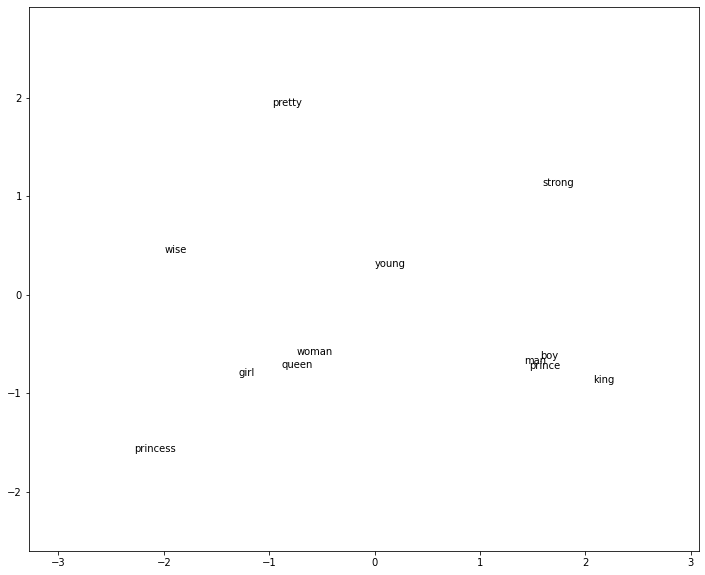

In [18]:
fig, ax = plt.subplots()
for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1, x2))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams['figure.figsize'] = [12, 10]
plt.show()